# Homework 05

## Assignment 2 CIFAR-10 Classification

In [1]:
# general imports
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

### 2.1 Prepare dataset

* information about the data
    * dataset size: 60 000 images (50 000 train, 10 000 test) 
    * classes: 10 classes (each has 6000 images - that means an even distribution of classes which is important for the informative value of e.g. accuracy scores); given in int64 
        * classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck	(4 inanimates, 6 animates)									
        * classes are completely mutually exclusive; e.g. there is no overlap between automobiles and trucks 
    * type of data: 32x32 colour images 
    * image size: shape=(32, 32, 3), dtype=uint8
    * color channels: 3 
     
    
* load data and preprocess

* visualize data example 

In [2]:
# loading data
(train_ds, test_ds), ds_info = tfds.load('cifar10', split =['train', 'test'],
                                               as_supervised =True , with_info = True )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete9QI1O1/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incomplete9QI1O1/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


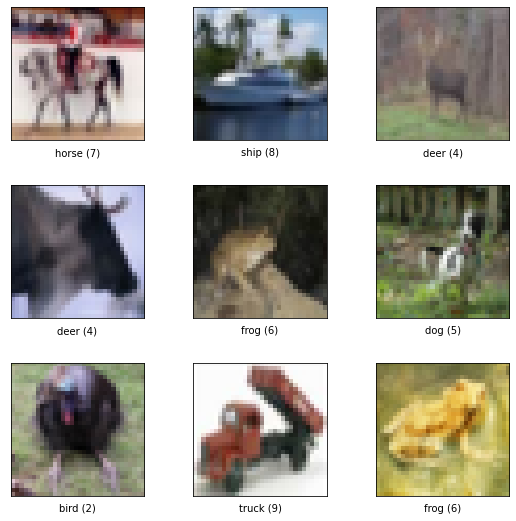

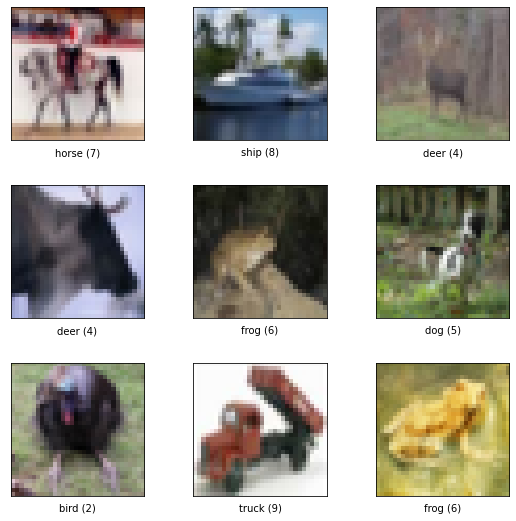

In [ ]:
# some examples of images in dataset
tfds.show_examples(train_ds, ds_info)

In [ ]:
# preprocessing

In [3]:
def preprocess_data(cifar):
    # convert data from uint8 to float32
    cifar = cifar.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # input normalization, bringing image values from range [0, 255] to [-1, 1]
    cifar = cifar.map(lambda img, target: (tf.cast(tf.image.per_image_standardization(img), tf.float32), target))
    # target vectors (one-hot encoding) for 10 classes
    cifar = cifar.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
                      
    # cache this progress in memory, as there is no need to redo it; it is deterministic after all
    cifar = cifar.cache()
    # shuffle, batch, prefetch
    cifar = cifar.shuffle(1000)
    cifar = cifar.batch(32)
    cifar = cifar.prefetch(20)
    
    # return preprocessed dataset
    return cifar

In [4]:
# pre-load some data
train_dataset = train_ds.apply(preprocess_data)
test_dataset = test_ds.apply(preprocess_data)

In [5]:
# visualize how the pre-processed data looks like
# Tensor with shape (batch-size, height, width, channels) for images 
# here: (32, 32, 32, 3)
# and Tensor with shape (batch-size, num_classes) for targets
# here: (32, 10)
iterator = iter(train_dataset)
iterator.get_next()

(<tf.Tensor: shape=(32, 32, 32, 3), dtype=float32, numpy=
 array([[[[-6.6436970e-01, -2.7820763e-01, -1.3015372e+00],
          [-6.2575352e-01, -1.8166709e-01, -1.2436129e+00],
          [-2.7820763e-01,  8.8646375e-02, -1.1277642e+00],
          ...,
          [ 5.0030164e-02,  6.0996521e-01, -1.1856886e+00],
          [-2.0097519e-01,  3.0103552e-01, -1.0891480e+00],
          [-3.1682384e-01,  1.0795448e-01, -1.0505319e+00]],
 
         [[-4.3267247e-01, -2.3959140e-01, -1.3594615e+00],
          [-4.3267247e-01, -1.2374278e-01, -1.3015372e+00],
          [-4.6510361e-02,  2.0449501e-01, -1.1277642e+00],
          ...,
          [ 6.9338270e-02,  5.9065711e-01, -9.7329938e-01],
          [-2.2028330e-01,  2.4311122e-01, -9.5399129e-01],
          [-1.6235898e-01,  2.6241931e-01, -8.7675887e-01]],
 
         [[-3.1682384e-01, -2.0097519e-01, -1.3015372e+00],
          [-2.5889951e-01, -8.5126571e-02, -1.2243048e+00],
          [-4.6510361e-02,  1.8518691e-01, -1.1277642e+00],
      

### 2.2 CNN Model 

* basic architecture

In [22]:
class CNN(tf.keras.Model):
    
    def __init__(self):
        
        super(CNN, self).__init__()
        
        # optimzer, metrics, loss
        self.optimizer = tf.keras.optimizers.Adam()
        
        self.metrics_list = [
                        tf.keras.metrics.Mean(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc") 
                       ]
        
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()   
        
        # layers
        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x
    
    # to reset metrics during training such that they don't accumulate every epoch
    def reset_metrics(self):
        
        for metric in self.metrics:
            metric.reset_states()
            
    # training and testing 
            
    @tf.function
    def train_step(self, data):
        
        x, targets = data
        
        # calculate and backpropagate gradients
        with tf.GradientTape() as tape:
            predictions = self(x, training=True)
            
            loss = self.loss_function(targets, predictions) + tf.reduce_sum(self.losses)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update loss metric
        self.metrics[0].update_state(loss)
        
        # update accuracy
        for metric in self.metrics[1:]:
            metric.update_state(targets,predictions)

        # Return a dictionary mapping metric names to current value to keep track of training
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        
        # same as in training but without backpropagating
        x, targets = data
        predictions = self(x, training=False)
        loss = self.loss_function(targets, predictions) + tf.reduce_sum(self.losses)
        # update loss metric
        self.metrics[0].update_state(loss)
        # update accuracy metric
        for metric in self.metrics[1:]:
            metric.update_state(targets, predictions)

        return {m.name: m.result() for m in self.metrics}


### 2.3 Training the network 

* hyperparameters
* loss function
* optimizer
* loss and accuracy for training and test data
* training loop with epochs = 15

In [7]:
def training_loop(model, train_ds, test_ds, epochs):
    
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch}:")
        
        # Training:
        
        for data in train_ds:
            metrics = model.train_step(data)
            
        # save and print the metrics
        # this is very ugly and takes way too many computations but i don't want to use the tensorboard
        for (key, value) in metrics.items():
            if key == 'acc':
                train_accuracies.append(value.numpy())
            if key == 'loss':
                train_losses.append(value.numpy())
                
            print(f"{key}: {value.numpy()}")
        
        # reset all metrics 
        model.reset_metrics()    
        
        # Testing:
        for data in test_ds:
            metrics = model.test_step(data)
            
        for (key, value) in metrics.items():
            if key == 'acc':
                test_accuracies.append(value.numpy())
            if key == 'loss':
                test_losses.append(value.numpy())
                
            print(f"test_{key}: {value.numpy()}")
                    

        # reset all metrics
        model.reset_metrics()
        print("\n")
        
    return train_losses, train_accuracies, test_losses, test_accuracies

In [9]:
# initialize model
model = CNN()
# run training loop 
train_loss, train_acc, test_loss, test_acc = training_loop(model=model, 
                train_ds=train_dataset, 
                test_ds=test_dataset, 
                epochs=15  
                )

Epoch 0:
loss: 1.672203779220581
acc: 0.37610000371932983
test_loss: 1.4093363285064697
test_acc: 0.489300012588501


Epoch 1:
loss: 1.287270426750183
acc: 0.5376600027084351
test_loss: 1.223475694656372
test_acc: 0.5636000037193298


Epoch 2:
loss: 1.138763427734375
acc: 0.595300018787384
test_loss: 1.069028615951538
test_acc: 0.6236000061035156


Epoch 3:
loss: 1.0411416292190552
acc: 0.6306399703025818
test_loss: 0.9935234189033508
test_acc: 0.6481000185012817


Epoch 4:
loss: 0.9814708232879639
acc: 0.6540200114250183
test_loss: 1.0061525106430054
test_acc: 0.6478000283241272


Epoch 5:
loss: 0.9279361367225647
acc: 0.6720799803733826
test_loss: 0.9495004415512085
test_acc: 0.6635000109672546


Epoch 6:
loss: 0.8896064162254333
acc: 0.6845999956130981
test_loss: 0.9251596927642822
test_acc: 0.6732000112533569


Epoch 7:
loss: 0.8498708605766296
acc: 0.697920024394989
test_loss: 0.870222806930542
test_acc: 0.6927000284194946


Epoch 8:
loss: 0.8142822980880737
acc: 0.714100003242492

### 2.4 Visualization


In [10]:
def visualization(train_losses, train_accuracies, test_losses, test_accuracies ):
    plt.figure()
    line1, = plt.plot(train_losses , "b-")
    line2, = plt.plot(test_losses , "r-")
    line3, = plt.plot(train_accuracies , "b:")
    line4, = plt.plot(test_accuracies , "r:")

    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1 , line2 , line3 , line4), 
             ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()

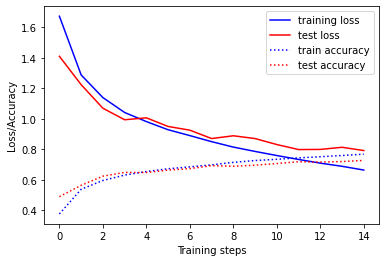

In [11]:
visualization(train_loss, train_acc, test_loss, test_acc)

## Assignment 3 Adjusting hyperparameters and architecture

* different combinations of layers 
* hyperparameters 
* optimizer 

### 3.1 Share results 

Epoch 0:
loss: 1.676883339881897
acc: 0.3641600012779236
test_loss: 1.3884735107421875
test_acc: 0.47839999198913574


Epoch 1:
loss: 1.2361352443695068
acc: 0.5533199906349182
test_loss: 1.0993422269821167
test_acc: 0.6044999957084656


Epoch 2:
loss: 1.0458446741104126
acc: 0.6291199922561646
test_loss: 1.0084446668624878
test_acc: 0.6341999769210815


Epoch 3:
loss: 0.9278566837310791
acc: 0.6696799993515015
test_loss: 0.964002788066864
test_acc: 0.65829998254776


Epoch 4:
loss: 0.8402810096740723
acc: 0.7012799978256226
test_loss: 0.869286298751831
test_acc: 0.6967999935150146


Epoch 5:
loss: 0.7752658128738403
acc: 0.7266600131988525
test_loss: 0.7954692840576172
test_acc: 0.7235000133514404


Epoch 6:
loss: 0.7125596404075623
acc: 0.748960018157959
test_loss: 0.7893752455711365
test_acc: 0.7263000011444092


Epoch 7:
loss: 0.6663481593132019
acc: 0.764739990234375
test_loss: 0.7983383536338806
test_acc: 0.7289999723434448


Epoch 8:
loss: 0.6223685145378113
acc: 0.7824199795722

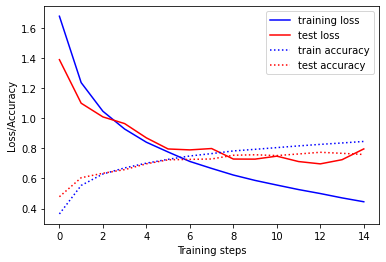

In [21]:
# initialize model with more conv. layers (4 conv.layers before each pooling, see next text cell) 
model2 = CNN()
# run training loop 
train_loss, train_acc, test_loss, test_acc = training_loop(model=model2, 
                train_ds=train_dataset, 
                test_ds=test_dataset, 
                epochs=15  
                )

visualization(train_loss, train_acc, test_loss, test_acc)

Model with changed layers:

layers:

        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.convlayer3 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.convlayer4 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer5 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.convlayer6 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.convlayer7 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.convlayer8 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')


In general results do not seem to improve that much except for taining loss witch gets a lot smaller.


Epoch 0:
loss: 1.5332227945327759
acc: 0.42838001251220703
test_loss: 1.1728405952453613
test_acc: 0.5802000164985657


Epoch 1:
loss: 1.0373622179031372
acc: 0.6323800086975098
test_loss: 0.9822473526000977
test_acc: 0.6452999711036682


Epoch 2:
loss: 0.8435878753662109
acc: 0.7067000269889832
test_loss: 0.7721898555755615
test_acc: 0.7296000123023987


Epoch 3:
loss: 0.7247719168663025
acc: 0.7480400204658508
test_loss: 0.780288577079773
test_acc: 0.734499990940094


Epoch 4:
loss: 0.6323719024658203
acc: 0.7784600257873535
test_loss: 0.7201510071754456
test_acc: 0.7587000131607056


Epoch 5:
loss: 0.5660786032676697
acc: 0.8027600049972534
test_loss: 0.7024912238121033
test_acc: 0.7694000005722046


Epoch 6:
loss: 0.5040769577026367
acc: 0.825219988822937
test_loss: 0.6579744219779968
test_acc: 0.7843000292778015


Epoch 7:
loss: 0.44886237382888794
acc: 0.843500018119812
test_loss: 0.7033711671829224
test_acc: 0.7807999849319458


Epoch 8:
loss: 0.4023330807685852
acc: 0.859780013

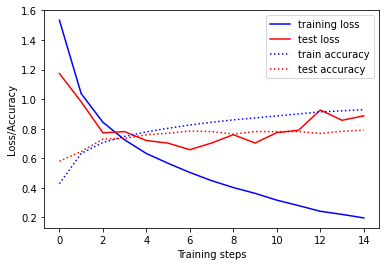

In [23]:
# initialize model with ... 
model3 = CNN()
# run training loop 
train_loss, train_acc, test_loss, test_acc = training_loop(model=model3, 
                train_ds=train_dataset, 
                test_ds=test_dataset, 
                epochs=15  
                )

visualization(train_loss, train_acc, test_loss, test_acc)

Model with changed layers:
 

        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)


        self.convlayer5 = tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding='same', activation='relu')
        self.convlayer6 = tf.keras.layers.Conv2D(filters=96, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')


Again, training loss gets close to zero but the testing remains at similar values (no real improvement). 